In [28]:
import pandas as pd # 
import numpy as np # 
import re # 
import sklearn # 
import xgboost as xgb # XGBoost
import seaborn as sns # 
import matplotlib.pyplot as plt # 
# Notebook
%matplotlib inline

# 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC # 
from sklearn.linear_model import LogisticRegression
##KA
# from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb

In [2]:
pos = pd.read_csv('newtrain.csv')
neu = pd.read_csv('newtrain_s.csv')
neg = pd.read_csv('newtrain_y.csv')

pos["target"] = [0 for i in range(pos.shape[0])]
neu["target"] = [1 for i in range(neu.shape[0])]
neg["target"] = [2 for i in range(neg.shape[0])]
train = pd.concat([pos, neu, neg], axis=0).fillna(0)

train = train.sample(frac=1)

train.head(3)

ID  BirthD  medicalD  age  Eye  Cornea Front K1  Cornea Front K2  \
788  789    1991      2013   22    0             43.0             43.9   
694  695    1979      2011   32    0             42.7             43.0   
203  204    1991      2010   19    0             43.9             46.1   

     Cornea Front Km  Cornea Front Astig  Cornea Front Q-val   ...    \
788             43.4                 0.9               -0.48   ...     
694             42.9                 0.3               -0.61   ...     
203             44.9                 2.2               -0.40   ...     

     WFA Cornea 12  WFA Cornea 13  WFA Cornea 14  WFA Cornea 15  \
788          0.005          0.112          0.038          0.035   
694          0.110          0.147          0.025         -0.034   
203          0.094          0.199          0.042         -0.029   

     WFA Cornea 16  WFA Cornea 17  WFA Cornea 18  WFA Cornea 19  \
788         -0.063          0.017          0.039          0.044   
694          0.003         -0.035         -0.004          0.008   
203          0.027          0.050         -0.021         -0.075   

     WFA Cornea 20  target  
788         -0.053       1  
694         -0.031       1  
203         -0.046       1  

[3 rows x 163 columns]

In [3]:

predictor = [x for x in train.columns if x not in ["target", "ID", "CTSP 10mm", "PTI 10mm"]]

features = train[predictor].values 
labels = train["target"].values
x_train = features[:2000]
x_test = features[2000:]
y_train = labels[:2000]
y_test = labels[2000:]


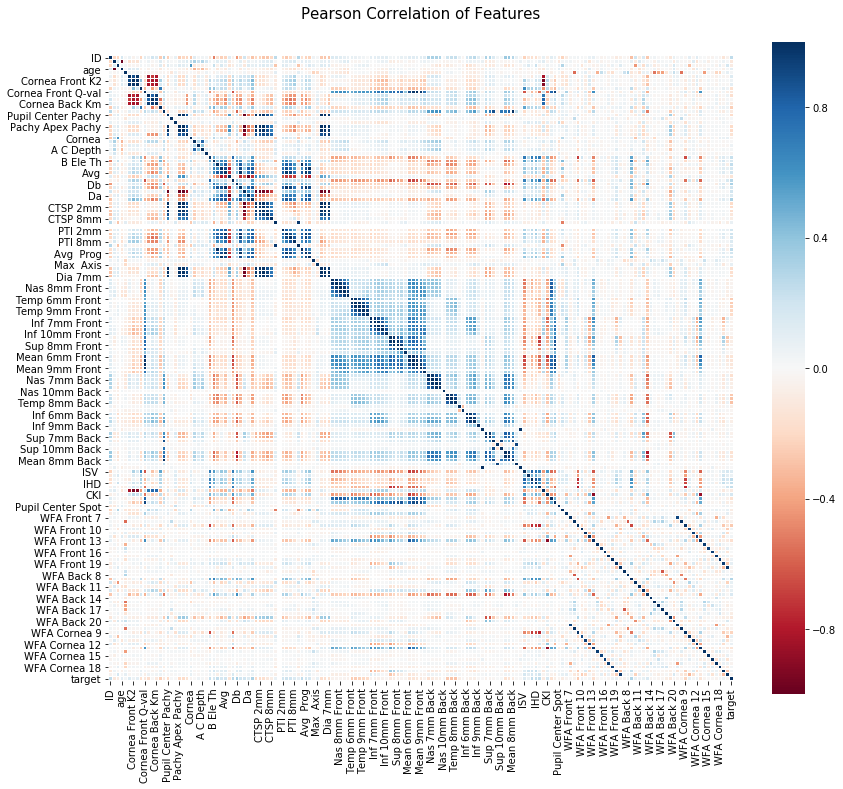

In [4]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white')

In [5]:
ntrain = x_train.shape[0]
ntest = x_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 3 # set folds for out-of-fold prediction
# kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)
kf = KFold(n_splits=NFOLDS, shuffle=False, random_state=SEED) ##KA

# Class to extend the Sklearn classifier
# 
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
        return self.clf.fit(x,y).feature_importances_ ##KA
    

In [6]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    # for i, (train_index, test_index) in enumerate(kf):
    for i, (train_index, test_index) in enumerate(kf.split(x_train)): ##KA
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [7]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
# Extra Trees
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
# AdaBoost
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
# Gradient Boosting
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
# Support Vector Classifier
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [8]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [9]:
# Create our OOF train and test predictions. These base results will be used as new features
# 
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) 

In [10]:
rf_features = rf.feature_importances(x_train,y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train,y_train)

[0.01105438 0.00109308 0.00816529 0.00028473 0.0058877  0.00333166
 0.00353016 0.05138303 0.00272518 0.00480499 0.00553498 0.00235119
 0.10187117 0.00306705 0.00331197 0.00557565 0.00295853 0.0036787
 0.00206164 0.00158075 0.00217251 0.00198175 0.00353314 0.00325763
 0.00403679 0.01592944 0.07305215 0.00748783 0.00837796 0.01450115
 0.00587553 0.01115081 0.03478274 0.01683692 0.00197539 0.00396351
 0.04226211 0.0019408  0.00285863 0.00334763 0.00315012 0.002564
 0.         0.01084455 0.01214922 0.0075693  0.00441354 0.00479281
 0.00720839 0.00417498 0.00198041 0.0025196  0.00130226 0.00175621
 0.00170776 0.00160648 0.00242462 0.00242103 0.00240522 0.00220242
 0.00509328 0.00653455 0.00633303 0.00794505 0.00616622 0.00205585
 0.00255013 0.00227609 0.00227466 0.00202059 0.00444966 0.00265048
 0.001848   0.00253032 0.00136712 0.00290329 0.00341199 0.00242892
 0.00267269 0.00207846 0.00279268 0.00331807 0.00171551 0.00176137
 0.00248174 0.00981475 0.00858904 0.00657738 0.00694389 0.0072374

In [12]:
cols = predictor
# Create a dataframe with features
# 
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [27]:
import heapq
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
print("RF")
a = feature_dataframe['Random Forest feature importances'].values.tolist()
re1 = map(a.index, heapq.nlargest(5, a))
#print(list(re1))
print(feature_dataframe['Random Forest feature importances'].values)
print(feature_dataframe['features'].values)
print(feature_dataframe['features'].values[list(re1)])
for item in list(re1):
  print(feature_dataframe['features'].values[item])    

data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]
print("ET")
a = feature_dataframe['Extra Trees  feature importances'].values.tolist()
re1 = map(a.index, heapq.nlargest(5, a))


print(feature_dataframe['Extra Trees  feature importances'].values)
print(feature_dataframe['features'].values)
for item in list(re1):
  print(feature_dataframe['features'].values[item])    


layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]
print("Ada")
a = feature_dataframe['AdaBoost feature importances'].values.tolist()
re1 = map(a.index, heapq.nlargest(5, a))

print(feature_dataframe['AdaBoost feature importances'].values)
print(feature_dataframe['features'].values)
for item in list(re1):
  print(feature_dataframe['features'].values[item])    


layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]
print("GBDT")
a = feature_dataframe['Gradient Boost feature importances'].values.tolist()
re1 = map(a.index, heapq.nlargest(5, a))
print(feature_dataframe['Gradient Boost feature importances'].values)
print(feature_dataframe['features'].values)
for item in list(re1):
  print(feature_dataframe['features'].values[item])    

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

RF
[0.01105438 0.00109308 0.00816529 0.00028473 0.0058877  0.00333166
 0.00353016 0.05138303 0.00272518 0.00480499 0.00553498 0.00235119
 0.10187117 0.00306705 0.00331197 0.00557565 0.00295853 0.0036787
 0.00206164 0.00158075 0.00217251 0.00198175 0.00353314 0.00325763
 0.00403679 0.01592944 0.07305215 0.00748783 0.00837796 0.01450115
 0.00587553 0.01115081 0.03478274 0.01683692 0.00197539 0.00396351
 0.04226211 0.0019408  0.00285863 0.00334763 0.00315012 0.002564
 0.         0.01084455 0.01214922 0.0075693  0.00441354 0.00479281
 0.00720839 0.00417498 0.00198041 0.0025196  0.00130226 0.00175621
 0.00170776 0.00160648 0.00242462 0.00242103 0.00240522 0.00220242
 0.00509328 0.00653455 0.00633303 0.00794505 0.00616622 0.00205585
 0.00255013 0.00227609 0.00227466 0.00202059 0.00444966 0.00265048
 0.001848   0.00253032 0.00136712 0.00290329 0.00341199 0.00242892
 0.00267269 0.00207846 0.00279268 0.00331807 0.00171551 0.00176137
 0.00248174 0.00981475 0.00858904 0.00657738 0.00694389 0.0072

ET
[0.0094644  0.00521649 0.00732431 0.00243501 0.0054355  0.00284499
 0.00269734 0.04990636 0.00211572 0.00807468 0.00639833 0.00290318
 0.08207512 0.00352198 0.0044652  0.00351505 0.00164008 0.00434754
 0.00517745 0.00318856 0.0094844  0.00355469 0.00202723 0.00470398
 0.00245079 0.01295877 0.0561271  0.00863089 0.00871266 0.01369729
 0.00573768 0.01075904 0.02875968 0.01170567 0.00525145 0.00676543
 0.03360267 0.00525286 0.00459076 0.00467459 0.00326202 0.00471661
 0.         0.02391383 0.01298343 0.00861348 0.0046777  0.00698954
 0.01345095 0.0096981  0.0016746  0.00366005 0.00462094 0.00425852
 0.00385422 0.00154872 0.00238704 0.00191224 0.00220616 0.00168478
 0.0071664  0.00866093 0.00692421 0.00627091 0.00470577 0.00159104
 0.00228724 0.00145271 0.00207929 0.00197888 0.0038029  0.00240282
 0.00329613 0.00242577 0.00147863 0.00178518 0.00144826 0.00229035
 0.00202351 0.00125649 0.00402198 0.00352107 0.00291527 0.00235117
 0.00116494 0.01752087 0.01108416 0.00974594 0.00527691 0.0

Ada
[0.004 0.002 0.004 0.    0.004 0.    0.002 0.008 0.    0.002 0.    0.
 0.064 0.006 0.    0.006 0.01  0.    0.    0.002 0.002 0.032 0.004 0.
 0.    0.    0.018 0.002 0.02  0.    0.004 0.01  0.082 0.004 0.002 0.
 0.034 0.    0.    0.002 0.    0.    0.    0.002 0.    0.    0.    0.
 0.    0.002 0.016 0.006 0.    0.    0.    0.002 0.002 0.01  0.008 0.
 0.01  0.    0.002 0.002 0.    0.002 0.    0.    0.    0.    0.002 0.004
 0.002 0.006 0.002 0.    0.002 0.    0.    0.002 0.018 0.002 0.    0.
 0.004 0.004 0.004 0.004 0.012 0.004 0.    0.004 0.006 0.    0.034 0.
 0.    0.012 0.002 0.004 0.004 0.006 0.004 0.    0.002 0.    0.01  0.012
 0.008 0.002 0.004 0.    0.    0.018 0.012 0.01  0.002 0.006 0.016 0.004
 0.    0.    0.    0.004 0.002 0.008 0.012 0.004 0.    0.022 0.004 0.002
 0.006 0.08  0.016 0.008 0.046 0.    0.002 0.    0.02  0.012 0.002 0.
 0.002 0.004 0.01  0.02  0.012 0.    0.01  0.    0.    0.002 0.012 0.006
 0.006 0.008 0.01 ]
['BirthD' 'medicalD' 'age' 'Eye' 'Cornea Front K1' 

GBDT
[6.07314860e-02 3.53967892e-04 5.07783140e-02 6.67575539e-06
 6.29374647e-04 1.51283278e-03 9.54811313e-04 2.52118586e-03
 3.17235175e-05 1.02572251e-03 1.71962430e-03 1.36952178e-05
 1.92959226e-01 5.38934047e-04 9.06529356e-04 1.96795046e-03
 8.48898384e-04 2.12992526e-03 1.18329364e-03 4.20726936e-03
 1.76664870e-03 1.38522983e-03 1.15544727e-03 1.52495032e-03
 1.96294180e-03 8.96302255e-03 1.20914647e-01 1.27209762e-03
 5.63668818e-04 8.67039168e-04 5.39700920e-04 5.88487935e-03
 6.70009703e-02 9.24041584e-03 3.78034720e-04 7.17882737e-04
 1.34293787e-01 1.82544314e-03 2.49718932e-04 3.51648353e-04
 2.10878795e-03 5.31232254e-05 0.00000000e+00 8.74429460e-03
 9.36947834e-04 1.35645989e-03 3.22667235e-04 4.02708423e-04
 4.72727513e-05 3.91233223e-05 1.34576042e-03 2.38102840e-03
 7.43854581e-04 5.61038808e-04 4.39954836e-03 4.43805053e-03
 6.90306232e-05 8.44869094e-04 5.82224352e-04 9.86121671e-04
 2.97302165e-03 1.15424200e-03 8.46682609e-03 8.51916048e-04
 2.57096469e-04 1.4